In [65]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='jdb3750', api_key='McHEWDV2if3O2lOImgN4')
import plotly.graph_objs as go
import plotly.figure_factory as ff
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, BORDERS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [66]:
od = pd.read_csv('overdose.csv') 
#display all column options
pd.set_option('display.max_columns', None)

In [67]:
od.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4083 entries, 0 to 4082
Data columns (total 32 columns):
CaseNumber               4083 non-null object
Date                     4081 non-null object
Sex                      4079 non-null object
Race                     4072 non-null object
Age                      4080 non-null float64
Residence City           3948 non-null object
Residence State          2116 non-null object
Residence County         3332 non-null object
Death City               4079 non-null object
Death State              2201 non-null object
Death County             3430 non-null object
Location                 4061 non-null object
DescriptionofInjury      1495 non-null object
InjuryPlace              4004 non-null object
ImmediateCauseA          4083 non-null object
Heroin                   2154 non-null object
Cocaine                  1176 non-null object
Fentanyl                 1467 non-null object
Oxycodone                547 non-null object
Oxymorphone        

In [68]:
od.DeathLoc[:1]

0    CT\n(41.544654, -72.651713)
Name: DeathLoc, dtype: object

In [69]:
od.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,Death County,Location,DescriptionofInjury,InjuryPlace,ImmediateCauseA,Heroin,Cocaine,Fentanyl,Oxycodone,Oxymorphone,EtOH,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
0,14-9876,06/28/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Acute fent, hydrocod, benzodiazepine",NaN,NaN,Y,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"CT\n(41.544654, -72.651713)"
1,12-16897,11/30/2012,Male,White,45.0,NaN,NaN,NaN,NEW HAVEN,NaN,NEW HAVEN,Other,NaN,Hotel or Motel,Fentanyl Intoxication,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW HAVEN, CT\n(41.308252, -72.924161)"
2,13-11849,08/12/2013,Male,White,30.0,NEW HAVEN,NaN,NaN,NEW HAVEN,NaN,NaN,Residence,NaN,Residence,Methadone and Cocaine Intoxication,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW HAVEN, CT\n(41.308252, -72.924161)"
3,14-17578,11/23/2014,Male,White,27.0,NAUGATUCK,NaN,NaN,NEW MILFORD,NaN,LITCHFIELD,Other,NaN,Other,Intoxication due to the combined effects of Ox...,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW MILFORD, CT\n(41.576633, -73.408713)"
4,12-11497,08/14/2012,Male,White,21.0,ENFIELD,NaN,NaN,ENFIELD,NaN,HARTFORD,Residence,NaN,Residence,Multiple Drug Toxicity,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"ENFIELD, CT\n(41.976501, -72.591985)"


In [70]:
# Strip all columns of white space
od = od.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
# Convert date to datetime format, then separate strings by year and month. This will be used for merging later on
od['Date'] = pd.to_datetime(od['Date'], format='%m/%d/%Y')
od['Year'] = od['Date'].dt.strftime('%Y')
od['Month'] = od['Date'].dt.strftime('%B')
# Change Death County Names to match the FIPS data for easier merging
od['Death County'].replace(
    ['FAIRFIELD', 'HARTFORD', 'LITCHFIELD','MIDDLESEX',
     'NEW HAVEN', 'NEW LONDON', 'TOLLAND', 'WINDHAM', 'USA'],
    ['Fairfield County', 'Hartford County', 'Litchfield County', 
     'Middlesex County', 'New Haven County', 'New London County',
     'Tolland County', 'Windham County', ''], inplace=True
)
# Make city names Title case instead of Upper case
od['Death City'] = od['Death City'].str.title()
# Extract coordinates from deathloc
coords = od.DeathLoc.str.extract( r'\(([^\,]+)\,([^\)]+)',expand=True)
od['Death Latitude'] = coords[0]
od['Death Longitude'] = coords[1]
od['Death Latitude'] = pd.to_numeric(od['Death Latitude'])
od['Death Longitude'] = pd.to_numeric(od['Death Longitude'])

# Shortening data set to only columns that I care about
od1 = od[
    ['Year','Month','Sex','Race','Age','Death City','Death County','Location','InjuryPlace','Heroin',
     'Cocaine','Fentanyl','Oxycodone','Oxymorphone','EtOH','Hydrocodone','Benzodiazepine','Methadone',
     'Amphet','Tramad','Morphine (not heroin)','Other','Any Opioid','Death Latitude','Death Longitude']
]
# Renamed 'Y' values as the names of the actual drugs so columns can be merged later on
od1['Heroin'].replace(['Y', 'y'], 'Heroin', inplace=True)
od1['Cocaine'].replace(['Y', 'y'], 'Cocaine', inplace=True)
od1['Fentanyl'].replace(['Y', 'Y POPS', 'Y (PTCH)', 'Y-A', 'y'], 'Fentanyl', inplace=True)
od1['Oxycodone'].replace(['Y', 'y'], 'Oxycodone',inplace=True)
od1['Oxymorphone'].replace('Y','Oxymorphone', inplace=True)
od1['EtOH'].replace(['Y', 'y'],'EtOH', inplace=True)
od1['Hydrocodone'].replace(['Y', 'y'],'Hydrocodone', inplace=True)
od1['Benzodiazepine'].replace(['Y', 'y'],'Benzodiazepine', inplace=True)
od1['Methadone'].replace(['Y', 'y'], 'Benzodiazepine', inplace=True)
od1['Amphet'].replace('Y','Amphetamine', inplace=True)
od1['Tramad'].replace('Y','Tramadol', inplace=True)
od1['Morphine (not heroin)'].replace(['Y', 'NO RX BUT STRAWS', 'STOLE MEDS',
                                      'y', 'PCP neg'],'Morphine', inplace=True)
# renaming the title of morhpine to make it more concise 
od1.rename(columns={'Morphine (not heroin)': 'Morphine'}, inplace=True)
od1['Other'].replace(
    ['MORPH NOS', 'OPIATES', 'BUPREN', 'DUSTER', 'HYDROMORPH',
     'MORPHINE', 'OPIATE', 'BUPRENO', 'COD', 'MITRAGINE', 'BUPRE',
     'MORPH', 'MORPHINE NO 6MAM', 'PCP', 'MORPHINE RX',
     'OPIATE IN HOSP?', 'GHB', 'DOXY, PHENOBARB', 'CODEINE',
     'POS 6-MAM', 'HYDR-MOR', 'OTHERS', 'BUPRENORPHINE',
     'BUPRENORPHONE', 'SNORTED', 'MEPERIDINE', 'MORPH PCP',
     'BUTALBITAL', 'TAPENTADOL', 'KETAMINE', 'ZOLP', 'H-MORPH',
     'ZOLPIDEM', 'OPIATE SCREEN', 'DOX, DIPHEN', 'MDMA', 'HYD-MORPH',
     'PAROX', 'SERT', 'BUPRENORP', 'HYDROMORP', 'MORPHIINE',
     'MORPHINE/COD', 'OPIOID', 'BUPRENORPH', 'HYDROM', 'BUTALB',
     'BATH SALT', 'TOPIRAMATE', 'HYDRMORP', 'KET',
     'MORPHINE/HYDROMORPH', 'BUPROP', 'PHENOBARB', '2-A', 'DIFLUOROETH',
     'MORPHIN', 'difluroethane', 'HYDRO MORPH', 'OPIOID NOS',
     'PCP, MORPHINE NOS', 'QUIET', 'codeine', 'DIFLUROR',
     'MORPHINE, HYDROMORPH', 'HYDROMORPHONE', 'DIFLOURO',
     'HYDROMORPHONE, BUPRENORPHONE', 'LSD, hydromorphone',
     'U-47700 synthetic opioid', 'LOPERAMIDE', 'Codeine',
     'hydromorphone', 'morphine', 'PCP, HYDROMORPH',
     'PCP, BUPRENORPHONE', 'Difluoroethane', 'MIRTAGYNINE', 'HYROMORPH',
     'DIFLURO', 'MORPH/COD', 'BUPRENORPHONE, DIFLUORO', 'HYDMORPH',
     'U-47700', 'CARFENTANIL', 'BUPRENOR', 'U47700', 'BUPRNO',
     'U-47700, CARFENTANIL', 'PCP, BUPRENOR', 'BUPRENOPHINE',
     'BUPRENOR, CARFENTANIL', 'BUPRNOR', 'DIPHEN, CHLORPHEN'],
     'Other', inplace=True
)
od1['Any Opioid'].replace(['Y','N','y'], 'Opioid', inplace=True)
# removing 'NaN' values
od1 = od1.replace('', np.nan, regex=True)

In [72]:
# Create dataframe using the census data
census = pd.read_csv('census.csv')
# KEY

# The key for  the YEAR variable  is  as follows: 
# 1 = 4/1/2010  Census population
# 2 = 4/1/2010  population  estimates  base
# 3 = 7/1/2010  population  estimate
# 4  =  7/1/2011  population  estimate 
# 5  =  7/1/2012  population  estimate 
# 6  =  7/1/2013  population  estimate 
# 7  =  7/1/2014  population  estimate 
# 8  =  7/1/2015  population  estimate 
# 9 = 7/1/2016  population  estimate
# 10  = 7/1/2017  population  estimate

# The key for  AGEGRP is  as follows: 
# 0 = Total
# 1 = Age 0 to  4 years
# 2 = Age 5 to  9 years
# 3 = Age 10  to 14  years
# 4 = Age 15  to 19  years
# 5 = Age 20  to 24  years
# 6 = Age 25  to 29  years
# 7 = Age 30  to 34  years
# 8 = Age 35  to 39  years
# 9 = Age 40  to 44  years
# 10  = Age 45 to  49  years
# 11  = Age 50 to  54  years
# 12  = Age 55 to  59  years
# 13  = Age 60 to  64  years
# 14  = Age 65 to  69  years
# 15  = Age 70 to  74  years
# 16  = Age 75 to  79  years
# 17  = Age 80 to  84  years
# 18  = Age 85 years or older

# converting the key to actual year values 
census = census[census['AGEGRP'] == 0]
census = census[census['YEAR'].isin([5, 6, 7, 8, 9, 10])]
census['YEAR'].replace(5, '2012-07-01',inplace=True)
census['YEAR'].replace(6, '2013-07-01',inplace=True)
census['YEAR'].replace(7, '2014-07-01',inplace=True)
census['YEAR'].replace(8, '2015-07-01',inplace=True)
census['YEAR'].replace(9, '2016-07-01',inplace=True)
census['YEAR'].replace(10, '2017-07-01',inplace=True)
census['YEAR'] = pd.to_datetime(census['YEAR'],format='%Y-%m-%d')
census['YEAR'] = census['YEAR'].dt.strftime('%Y')

# creating the FIPS column here using State Fips code and the County Fips code.
census['STATE'] = census['STATE'].apply('{:0>2}'.format)
census['COUNTY'] = census['COUNTY'].apply('{:0>3}'.format)
census['Fips Code'] = (census['STATE'].astype(str) + census['COUNTY'].astype(str)).astype(int)

# Creating a dataset with only info that i care about and then renaming columns to look nicer. 
# Also named the County 'Death County' so I could merge dataframes
censusbrief = census[['Fips Code', 'STNAME', 'CTYNAME', 'YEAR', 'TOT_POP', 'TOT_MALE', 'TOT_FEMALE']]
censusbrief.rename(columns = {'STNAME':'State','CTYNAME':'Death County','YEAR':'Year',
                              'TOT_POP':'Population','TOT_MALE':'Male','TOT_FEMALE':'Female'}, inplace=True)
censusbrief.head()

,Fips Code,State,Death County,Year,Population,Male,Female
76,9001,Connecticut,Fairfield County,2012,936345,455731,480614
95,9001,Connecticut,Fairfield County,2013,942865,459001,483864
114,9001,Connecticut,Fairfield County,2014,946547,461029,485518
133,9001,Connecticut,Fairfield County,2015,948116,461741,486375
152,9001,Connecticut,Fairfield County,2016,949191,462357,486834


In [73]:
# Merge dataframes on 'Death County' and 'Year' so that population data will be correct
od_census = pd.merge(od1, censusbrief, on = ['Year', 'Death County'], how = 'outer')
# Create a new column filled with the number of deaths per column and county
countydeaths = od_census.groupby(['Year', 'Death County']).agg('size').to_frame()
countydeaths.rename(columns={0: 'Deaths'}, inplace=True)
od_census = pd.merge(od_census, countydeaths, on=['Death County', 'Year'], how='outer')
# Sort the data by year and month chronologically
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']
od_census['Month'] = pd.Categorical(od_census['Month'], categories=months, ordered=True)
# sorting dataframe chronologically 
od_census.sort_values(by = ['Year', 'Month'], ascending=True, inplace=True)
od_census.reset_index(drop=True, inplace=True)
od_census.head()

,Year,Month,Sex,Race,Age,Death City,Death County,Location,InjuryPlace,Heroin,Cocaine,Fentanyl,Oxycodone,Oxymorphone,EtOH,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine,Other,Any Opioid,Death Latitude,Death Longitude,Fips Code,State,Population,Male,Female,Deaths
0,2012,January,Male,White,56.0,Hamden,New Haven County,Residence,Residence,NaN,Cocaine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.382918,-72.907743,9009.0,Connecticut,865335.0,416866.0,448469.0,99.0
1,2012,January,Male,White,35.0,Middlebury,New Haven County,Other,Residence,Heroin,Cocaine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.529492,-73.127625,9009.0,Connecticut,865335.0,416866.0,448469.0,99.0
2,2012,January,Male,White,35.0,New Haven,New Haven County,Hospital,Unknown,Heroin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.308252,-72.924161,9009.0,Connecticut,865335.0,416866.0,448469.0,99.0
3,2012,January,Male,White,46.0,East Haven,New Haven County,Residence,Residence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benzodiazepine,NaN,NaN,NaN,NaN,NaN,41.277971,-72.871954,9009.0,Connecticut,865335.0,416866.0,448469.0,99.0
4,2012,January,Male,White,51.0,Waterbury,New Haven County,Residence,Residence,NaN,NaN,NaN,NaN,NaN,EtOH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.554261,-73.043069,9009.0,Connecticut,865335.0,416866.0,448469.0,99.0


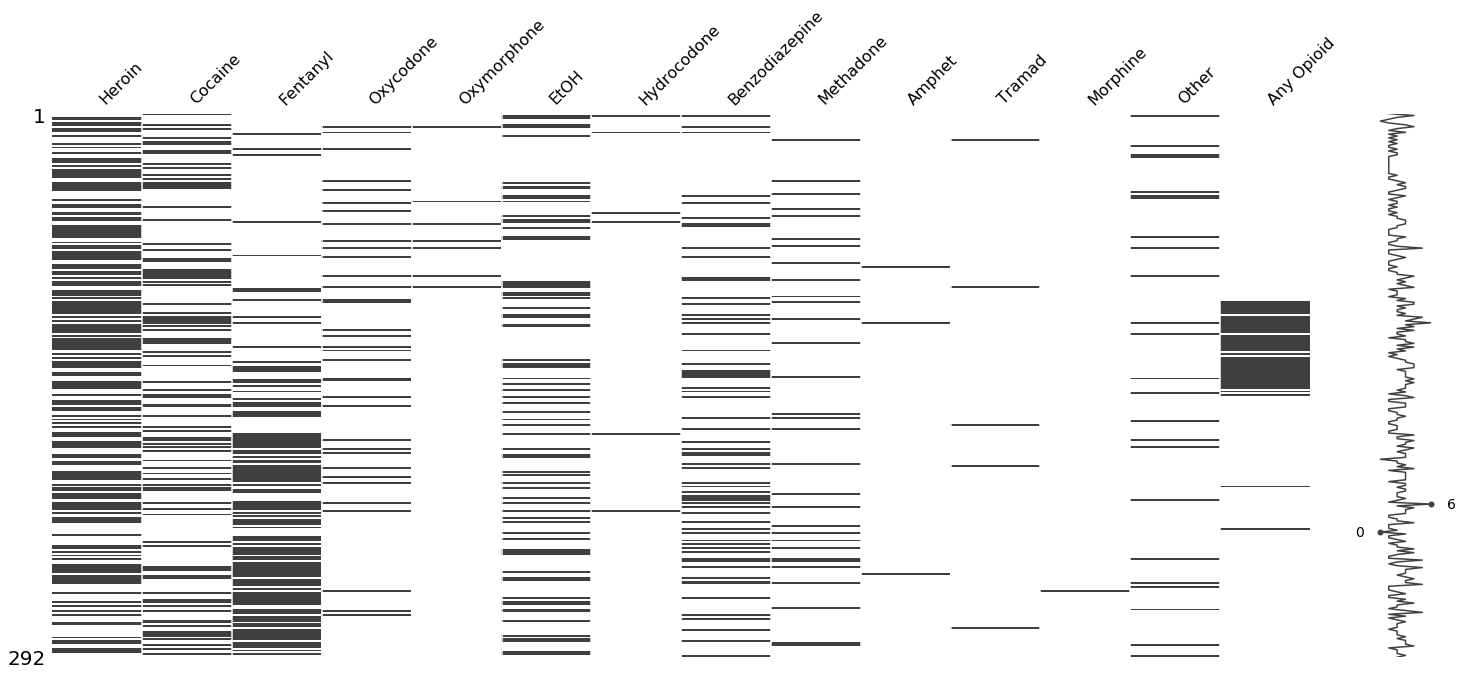

In [74]:
# using the package missingo to visualize the dataset. the package is originally used for finding
# missing values within the columns, but we're using it to show frequency/distribution.
# the black bars represent the values that are present and the blank spaces represent the missing vals.
drugs = od_census[
    ['Heroin','Cocaine','Fentanyl','Oxycodone','Oxymorphone','EtOH',
     'Hydrocodone','Benzodiazepine','Methadone','Amphet','Tramad',
     'Morphine','Other','Any Opioid']
]
%matplotlib inline
msno.matrix(drugs[::14])

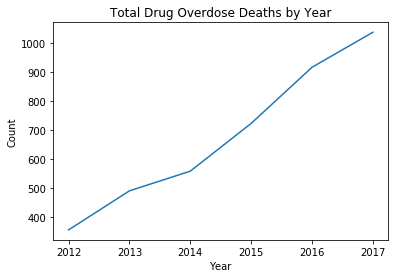

In [75]:
year = od_census['Year'].value_counts(ascending=True).drop('NaT')
plt.plot(year)
plt.title('Total Drug Overdose Deaths by Year')
plt.xlabel('Year')
plt.ylabel('Count');

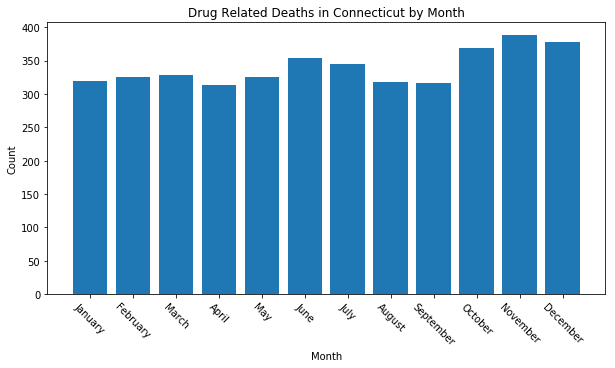

In [76]:
months = od_census['Month'].value_counts(sort=False).to_frame()
plt.figure(figsize=(10, 5))
plt.bar(months.index,months['Month'])
plt.title('Drug Related Deaths in Connecticut by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=-45);

In [78]:
# using the package plotly to create an interactive choropleth map by county 
values = od_census['Fips Code'].value_counts(sort=True).tolist()
# the fips codes are unique identifiers that use numeric assignments from the states/counties
fips = od_census['Fips Code'].value_counts(sort=True).index.tolist()

endpts = list(np.mgrid[min(values):max(values):4j])
colorscale = ["#f7fbff", "#d2e3f3", "#9ecae1", "#57a0ce", 
              "#2171b5", "#0b4083","#08306b"]
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Connecticut'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=[100,300,500,700,900,1000], round_legend_values=True,
    plot_bgcolor='rgb(255,255,255)',
    paper_bgcolor='rgb(255,255,255)',
    legend_title='Count',
    county_outline={'color': 'rgb(255,255,255)', 'width': 1},
    title='Deaths by County',
    exponent_format=True,
)
py.iplot(fig, filename='death_by_county')

C:\Users\jdb3750\AppData\Local\Continuum\anaconda2\envs\test\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [79]:
# interactive pie chart using plotly to show the percent of drug related deaths occurred per county
fig = {
  "data": [
    {
      "values": od_census['Death County'].value_counts(),
      "labels": od_census['Death County'].value_counts().index,
      "textposition":"inside",
      "name": "Overdose By County",
      "hoverinfo":"label+percent+name",
      "type": "pie"
    }],
  "layout": {
        "title":"Drug Related Deaths by County, 2012-2017"
    }
}
py.iplot(fig, filename='donut')

C:\Users\jdb3750\AppData\Local\Continuum\anaconda2\envs\test\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



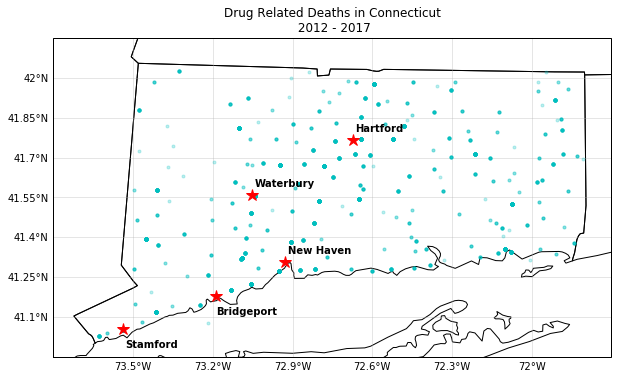

In [80]:
# using matplotlib to create a map of all of the deaths (with lat/lon info)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([-73.8, -71.7, 40.95, 42.15])

# creating separate lists with the five most populated cities with coords
cities = ['Bridgeport', 'New Haven', 'Hartford', 'Stamford', 'Waterbury']
cities_lat = [41.1792, 41.3083, 41.7658, 41.0534, 41.5582]
cities_lon = [-73.1894, -72.9279, -72.6734, -73.5387, -73.0515]

# create the state borders with the scale set to 10m for higher resolution
states = NaturalEarthFeature(category='cultural', scale='10m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, edgecolor ='black')

# added grdilines and the lat/lon tick marks 
gl = ax.gridlines(draw_labels=True, alpha=0.4)
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER

# plotting the deaths as well as the biggest cities
ax.plot(od_census['Death Longitude'], od_census['Death Latitude'], 'c.', alpha=0.25)
ax.plot(cities_lon, cities_lat, 'r*', markersize=12)
ax.text(cities_lon[0], cities_lat[0] - 0.07, cities[0], weight = 'bold')
ax.text(cities_lon[1] + 0.01, cities_lat[1] + 0.03, cities[1], weight='bold')
ax.text(cities_lon[2] + 0.01, cities_lat[2] + 0.03, cities[2], weight='bold')
ax.text(cities_lon[3] + 0.01, cities_lat[3] - 0.07, cities[3], weight='bold')
ax.text(cities_lon[4] + 0.01, cities_lat[4] + 0.03, cities[4], weight='bold')
plt.title('Drug Related Deaths in Connecticut\n 2012 - 2017')
plt.show()

In [81]:
#plotting the male vs female injuryPlace
#male
males = od_census[od_census['Sex'] == 'Male']
m_IP = males['InjuryPlace'].value_counts()
#condensing and organizing the male data
#Combining all injuries into categories
m_IP['Residential'] = (
    m_IP['Residence'] + m_IP['Residential Building'] + m_IP['House'] + m_IP['Apartment'] 
    + m_IP['Porch'] + m_IP['Nursing Home'] + m_IP['Building'] + m_IP['residence'] 
    + m_IP['Apartment House'] + m_IP['Garage'] + m_IP['residential building'] 
    + m_IP["Friend's Residence"] + m_IP['Rest Home'] + m_IP['Other, Farm or Ranch'] 
    + m_IP['homeless shelter'] + m_IP['Other indoor Area'] + m_IP['Backyard'] 
    + m_IP['Other, Residential Institution']
)
m_IP['In Public'] = (
    m_IP['Hotel or Motel'] + m_IP['Other, Other Outdoor Area'] 
    + m_IP['Restaurant'] + m_IP['Other, Park or Recreational Area'] 
    + m_IP['Other, Public Buildings'] + m_IP['Sidewalk'] + m_IP['Public Park'] 
    + m_IP['Office Building'] + m_IP['Yard'] + m_IP['Store or Shopping Area'] 
    + m_IP['Bar or Night Club'] + m_IP['Forest, Wooded Area'] + m_IP['Shed'] 
    + m_IP['Field'] + m_IP['Warehouse'] + m_IP['Alleyway'] + m_IP['Beach'] 
    + m_IP['University or College'] + m_IP['Railroad Track'] + m_IP['Convenience Store'] 
    + m_IP['Cemetery'] + m_IP['Church'] + m_IP['Public Park, Urban or Suburban'] 
    + m_IP['Casino'] + m_IP['School, Primary or Secondary'] + m_IP['Field'] 
    + m_IP['Other, Industrial Area']
)
m_IP['Vehicles'] = (
    m_IP['In Vehicle'] + m_IP['Automobile'] + m_IP['Parking Lot'] + m_IP['Street'] 
    + m_IP['Roadway'] + m_IP['Gas Station'] + m_IP['Driveway'] 
    + m_IP['Train or Subway Station'] + m_IP['Boat/Marina'] + m_IP['car in hartford']
)
m_IP['Treatment'] = (
    m_IP['Hospital'] + m_IP['Halfway House'] + m_IP['Hospital or Emergency Room'] 
    + m_IP['Other, Health Care Facility'] + m_IP['Rehab House']
)
m_IP['Others'] = m_IP['Other'] + m_IP['Unknown'] + m_IP['Other (unknown)']

odm = m_IP.to_frame().tail()

In [103]:
#plotting the male vs female injuryPlace
#male
females = od_census[od_census['Sex'] == 'Female']
f_IP = females['InjuryPlace'].value_counts()
#condensing and organizing the female data
#Combining all injuries into categories
f_IP['Residential'] = (
    f_IP['Residence'] + f_IP['Residential Building'] + f_IP['Hotel or Motel'] 
    + f_IP['House'] + f_IP['Apartment'] + f_IP['Apartment House'] + f_IP['Porch'] 
    + f_IP['Other, Residential Institution'] + f_IP['Garage'] + f_IP['Backyard'] 
    + f_IP['Other indoor Area']
)
f_IP['In Public'] = (
    f_IP['Other, Other Outdoor Area'] + f_IP['Restaurant'] + f_IP['Stairs'] 
    + f_IP['Forest, Wooded Area'] + f_IP['Building'] + f_IP['Store or Shopping Area'] 
    + f_IP['Shopping Center'] + f_IP['Campgrounds'] + f_IP['Field'] + f_IP['Casino'] 
    + f_IP['Alleyway'] + f_IP['Other, Public Buildings'] + f_IP['Other, Industrial Area']
)
f_IP['Vehicles'] = (
    f_IP['In Vehicle'] + f_IP['Automobile'] + f_IP['Parking Lot'] + f_IP['Driveway'] 
    + f_IP['Street']
)
f_IP['Treatment'] = f_IP['Hospital'] + f_IP['Detoxification Center'] + f_IP['Halfway House']
f_IP['Others'] = (
    f_IP['Other'] + f_IP['Unknown'] + f_IP['Other (unknown)'] + f_IP['Multiple Locations']
)

odf = f_IP.to_frame().tail()

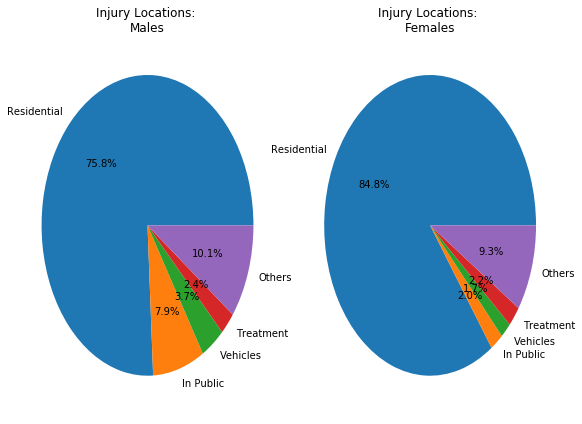

In [83]:
# pie charts to show the injury locations comparison between men and women
plt.figure(figsize=(8,6))

plt.subplot(121)
plt.pie(odm, labels=odm.index, autopct='%1.1f%%')
plt.title('Injury Locations: \nMales')

plt.subplot(122)
plt.pie(odf, labels=odf.index, autopct='%1.1f%%');
plt.title('Injury Locations: \nFemales')

plt.tight_layout()
plt.show()

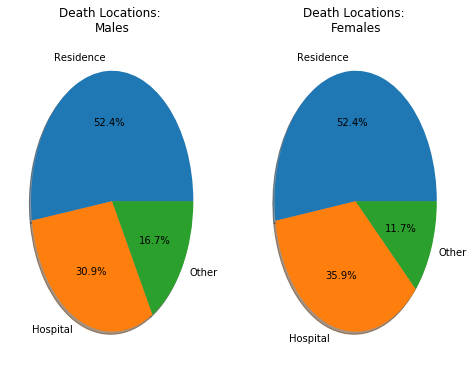

In [102]:
# death locations by males
males = od_census[od_census['Sex'] == 'Male']
m_loc = males['Location'].value_counts()

# Missing Convalescent Home and Hospice are too small to be significant, combining them into Other
m_loc['Other'] = m_loc['Other'] + m_loc['Convalescent Home'] + m_loc['Hospice']
m_loc = m_loc.drop(['Convalescent Home', 'Hospice'])

mlabels = ['Residence', 'Hospital', 'Other']


# death locations by female
females = od_census[od_census['Sex'] == 'Female']
f_loc = females['Location'].value_counts()

flabels = ['Residence', 'Hospital', 'Other']

# plotting males and females 
plt.figure(figsize = (8,6))

plt.subplot(121)
plt.pie(m_loc, shadow=True, labels=mlabels, autopct='%1.1f%%')
plt.title('Death Locations: \nMales')

plt.subplot(122)
plt.pie(f_loc, shadow=True, labels=flabels, autopct='%1.1f%%');
plt.title('Death Locations: \nFemales')

plt.show()

In [84]:
def Age_group(od_census):
    if od_census['Age'] < 20:
        return 0
    if od_census['Age'] < 30:
            return 1
    if od_census['Age'] < 40:
            return 2
    if od_census['Age'] < 50:
            return 3  
    if od_census['Age'] < 60:
            return 4
    if od_census['Age'] < 70:
            return 5
    if od_census['Age'] < 80:
            return 6
    if od_census['Age'] < 90:
            return 7
    if od_census['Age'] < 100:
            return 8
    return 'Null Value'
od_census['Age Group'] = od_census.apply(lambda od: Age_group(od), axis=1)

In [85]:
df = od_census['Age Group'].value_counts(sort=False)
df.index = range(9)

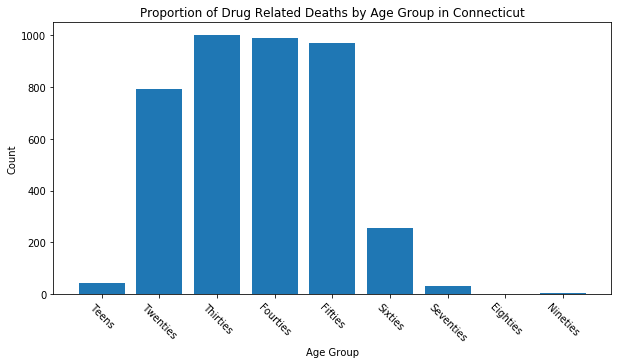

In [86]:
names = ['Teens', 'Twenties', 'Thirties', 'Fourties', 'Fifties', 'Sixties', 'Seventies','Eighties', 'Nineties']
plt.figure(figsize=(10,5))
plt.bar(df.index, df, tick_label=names)
plt.title('Proportion of Drug Related Deaths by Age Group in Connecticut')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=-45);

In [99]:
table = pd.crosstab(index=od_census['Race'], columns=od_census['Sex'], margins=True, dropna=True)

def Racee(od_census):
    if od_census['Race'] == 'Asian Indian':
        return 0
    if od_census['Race'] == 'Asian, Other':
        return 0
    if od_census['Race'] == 'Black':
        return 1
    if od_census['Race'] == 'Chinese':
        return 0
    if od_census['Race'] == 'Hawaiian':
        return 2
    if od_census['Race'] == 'Hispanic, Black':
        return 3
    if od_census['Race'] == 'Hispanic, White':
        return 3
    if od_census['Race'] == 'Native American, Other':
        return 4
    if od_census['Race'] == 'White':
        return 5
    if od_census['Race'] == 'NaN':
        return 6
    if od_census['Race'] == 'Other':
        return 6
    if od_census['Race'] == 'Unknown':
        return 6
od_census['Race'] = od_census.apply(lambda od: Racee(od), axis=1)

In [100]:
def Racename(i):
    print(type(i))
    if i == 0.0:
        return 'Asian'
    if i == 1.0:
        return 'Black'
    if i == 2.0:
        return 'Hawaiian'
    if i == 3.0:
        return 'Hispanic'
    if i == 4.0:
        return 'Native American'
    if i == 5.0:
        return 'White'
    if i == 6.0:
        return 'Unknown'
    if i == 'All':
        return 'All'
    else:
        return 'Null'

In [101]:
table

Sex,Female,Male,All
Race,,,
0.0,9,16,25
1.0,86,243,329
2.0,0,1,1
3.0,82,365,447
4.0,0,1,1
5.0,901,2343,3244
6.0,3,20,23
All,1081,2989,4070


In [97]:
#plotting drug type by year

import functools

year_drugs = od_census[['Year','Heroin','Cocaine','Fentanyl','Oxycodone',
            'Oxymorphone','EtOH','Hydrocodone','Benzodiazepine','Methadone',
            'Amphet','Tramad', 'Morphine', 'Other', 'Any Opioid']]

#Creating Dataframes of counts of each drugtype by year
her = year_drugs.groupby('Year', as_index=False)['Heroin'].count()
coc = year_drugs.groupby('Year', as_index=False)['Cocaine'].count()
fen = year_drugs.groupby('Year', as_index=False)['Fentanyl'].count()
oxy = year_drugs.groupby('Year', as_index=False)['Oxycodone'].count()
oxym = year_drugs.groupby('Year', as_index=False)['Oxymorphone'].count()
etoh = year_drugs.groupby('Year', as_index=False)['EtOH'].count()
hyd = year_drugs.groupby('Year', as_index=False)['Hydrocodone'].count()
ben = year_drugs.groupby('Year', as_index=False)['Benzodiazepine'].count()
met = year_drugs.groupby('Year', as_index=False)['Methadone'].count()
amp = year_drugs.groupby('Year', as_index=False)['Amphet'].count()
tra = year_drugs.groupby('Year', as_index=False)['Tramad'].count()
mor = year_drugs.groupby('Year', as_index=False)['Morphine'].count()
oth = year_drugs.groupby('Year', as_index=False)['Other'].count()
opi = year_drugs.groupby('Year', as_index=False)['Any Opioid'].count()

#merging each of the frames by year
drug_frames = [her, coc, fen, oxy, oxym, etoh, hyd, ben, met, amp, tra, mor, oth, opi] 

drugs_merged = functools.reduce(lambda left, right: pd.merge(left, right, on=['Year'],
                                            how='outer'), drug_frames)

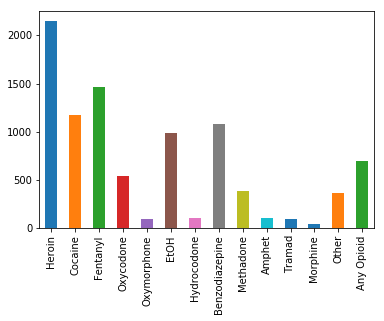

In [91]:
# bar chart for the types of drugs
drop_year = drugs_merged.sum()
drop_year[1:].plot(kind='bar');

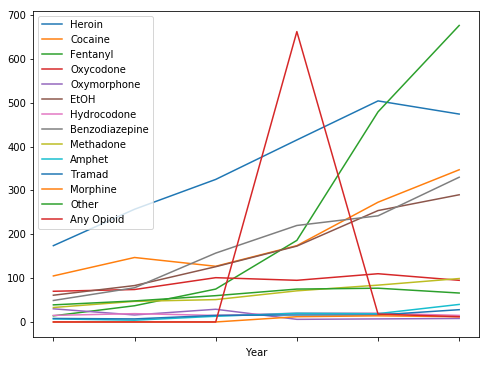

In [92]:
# line graph to show the popularity of specific drugs over time
drugs_merged = drugs_merged[:6]
drugs_merged.set_index('Year').plot(figsize=(8,6));